# Domain-Adversarial Training of Neural Networks

This notebook contains an implementation of the DANN algorithm to adapt domain, including 4 different examples.

Ganin Y. et al. (2017) Domain-Adversarial Training of Neural Networks. In: Csurka G. (eds) Domain Adaptation in Computer Vision Applications. Advances in Computer Vision and Pattern Recognition. Springer, Cham. https://doi.org/10.1007/978-3-319-58347-1_10

Based on the following implementation:
https://github.com/vcoyette/DANN

 ## Datasets
 
Download the MNIST_M dataset [here](https://github.com/ShichengChen/Domain-Adversarial-Training-of-Neural-Networks/tree/master/mnist_m), the Office dataset [here](https://drive.google.com/file/d/0B4IapRTv9pJ1WGZVd1VDMmhwdlE/view), the Synthetic Signs [here](https://www.dropbox.com/s/7izi9lccg163on1/synthetic_data.zip?dl=0) and the GTSRB [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html).
<br>
Alternatively, use the ones provided with this code.

Place the archives in the data folder:

MNIST Dataset - data/MNIST (automatically downloaded to data folder)
<br>
MNIST_M - data/mnist_m
<br>
Office - data/office
<br>
Synthetic Signs - data/synsigns
<br>
GTSRB - data/GTSRB

## Initialisation

In [8]:
# Loading libraries
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from task_definition import tasks
from test import testBaseLine, testDANN
import time
import sys
import pickle
from sklearn.manifold import TSNE

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using '+str(device))

Using cuda


# Task selection

Select the domain adaptation task to perform:

In [10]:
# Select source and target domains
# Available values:

#   0. MNIST to MNIST_M
#   1. SVHN to MNIST
#   2. AMAZON to WEBCAM
#   3. Syn Signs to GTSRB

domain = 0

The tasks are defined in the task_selection.py file.

In [11]:
task = tasks[domain]

Next we extract utils and networks for the specified task:

In [12]:
# Dataset loaders
load_source = task.load_source
load_target = task.load_target

# Network layers and parameters for specified datasets
FeatureExtractor = task.feature_extractor
Classifier = task.classifier
DomainRegressor = task.domain_regressor
schedule_lr = task.schedule_lr

## Load Dataset

Load the source and target datasets. If it's taking too long, you may check the progress in the "dataset_temp.txt" temporary file.

In [13]:
batch_size = 128 # choose accordingly with your machine limitations
pre_load_files = 1 # choose wheter to load files on demand or pre-load files in usage
                   # pre-loading is useful for training, but pointless to just see the images

# Extracting source dataset
trainloader_source, testloader_source = load_source(pre_load_files=pre_load_files,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    num_workers=0,
                                                    drop_last=True)

# Extracting target dataset
trainloader_target, testloader_target = load_target(pre_load_files=pre_load_files,
                                                    batch_size=batch_size, 
                                                    shuffle=True, 
                                                    num_workers=0,
                                                    drop_last=True)

We may plot the dataset to check if it's working correctly:

Source Domain batch


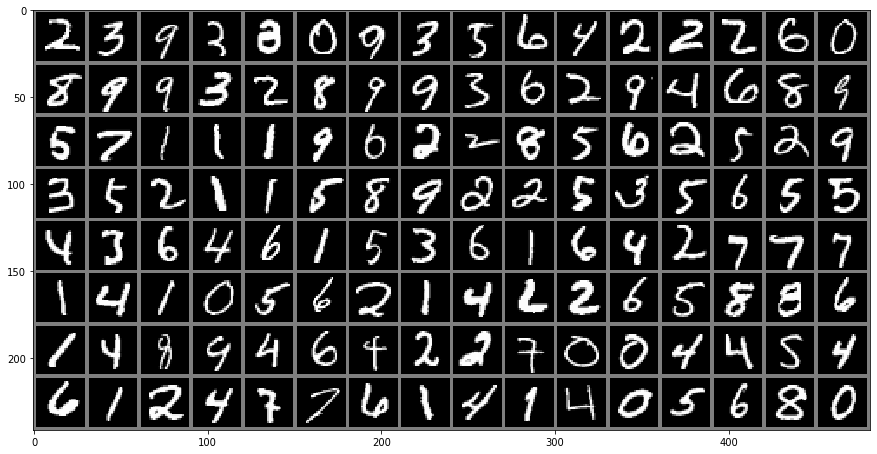

Target Domain batch


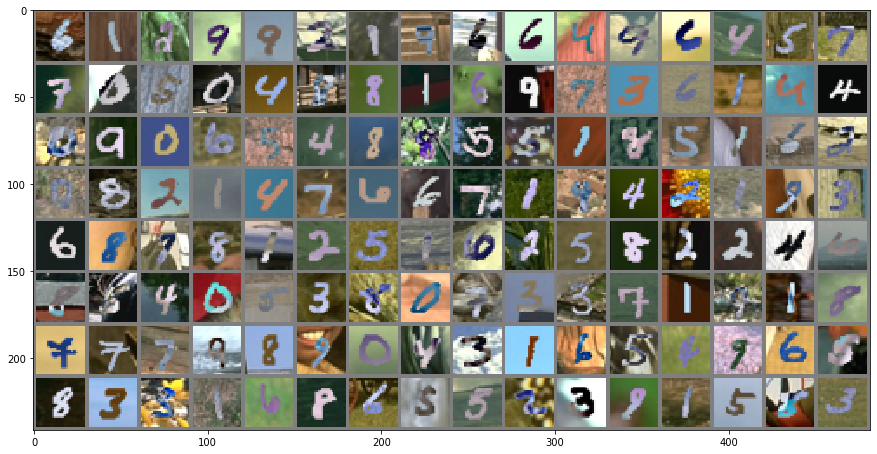

In [14]:
# Function to show image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.figure(figsize = (15, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()

# Getting some random training images from source
dataiter = iter(trainloader_source)
images, labels = dataiter.next()

print('Source Domain batch')

# Show images
imshow(torchvision.utils.make_grid(images, nrow=16))

# Getting some random training images from target
dataiter = iter(trainloader_target)
images, labels = dataiter.next()

print('Target Domain batch')

# Show images
imshow(torchvision.utils.make_grid(images, nrow=16))

# Baseline

Let's consider as a baseline a network trained on the source domain only. To remain consistent with the DANN implementation, we will use the same components (feature extractor and classifier).

In [15]:
# Defining baseline network class
class Net(nn.Module):
    
    # initialising modules
    def __init__(self, feature_extractor, classifier):
        super(Net, self).__init__()

        self.feature_extractor = feature_extractor
        self.classifier = classifier

    # forward step, basically, a feature extractor coupled by a classifier
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)

        return x

# Creating instance of baseline network
basenet = Net(FeatureExtractor(), Classifier()).to(device)

We define the loss as the negative log likelihood (NLL) loss, because it is useful to train a classification problems with N classes, which is the case of the examples in this notebook.

The optimizer will be a simple stochastic gradient (SGD) descent with a learning rate (LR) of 0.001 and a momentum of 0.9.

In [16]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(basenet.parameters(), lr=0.01, momentum=0.9)

We will train this baseline classifier for a number of epochs and only in the source domain.

In [10]:
n_epochs = 10 # define number of epochs

# start training
for epoch in range(n_epochs):

    print(f'Training epoch {epoch}...')

    # iterate through the source dataset
    for i, data in enumerate(trainloader_source):
        
        # extract images and labels
        inputs, labels = data[0].to(device), data[1].to(device)

        # get network outputs and calculate loss
        outputs = basenet(inputs)
        loss = criterion(outputs, labels)

        # empty optimizer, propagate loss and advance optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# training finished
print('Finished Training')

Training epoch 0...
Training epoch 1...
Training epoch 2...
Training epoch 3...
Training epoch 4...
Training epoch 5...
Training epoch 6...
Training epoch 7...
Training epoch 8...
Training epoch 9...
Finished Training


Then, we will try to predict the target dataset using this network and see how it will perform in the task. This evaluation will be further used to compare with the improvements provided by the DANN network.

In [22]:
print(f'Accuracy on the source test images:'
      f'{testBaseLine(basenet, testloader_source)} %')

print(f'Accuracy on the target test images:'
      f'{testBaseLine(basenet, testloader_target)} %')

Accuracy on the source test images:99.14863782051282 %
Accuracy on the target test images:60.59151785714286 %


We may then visualize the data representations learned by the network. To do so, the authors propagate some sample images of each dataset through the network and obtain the raw features from the top layer of the feature extraction layers. Then, the authors use a dimensionality reduction technique in order to reduce the network output to only two dimensions. This way, the features may be plotted in a graph and visualized.

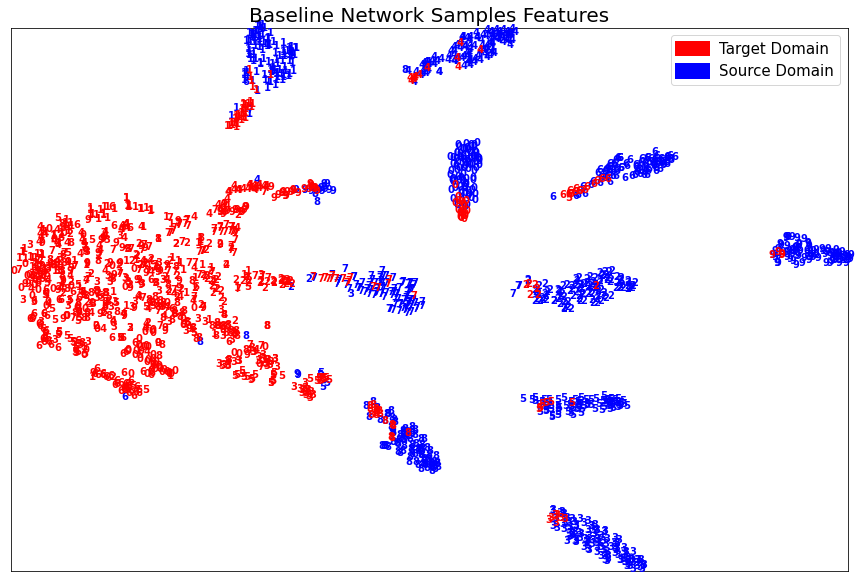

In [12]:
# Setup the network for evaluation
basenet.eval()

# Randomly select samples from source domain and target domain
num_of_samples = 1000 # number of samples
# lists to store images and labels
s_images, s_labels, s_tags = [], [], []
torch.manual_seed(0) # fixed seed for reproducibility

# Iterating through the source dataset
for images, labels in testloader_source:
    s_images.append(images.to(device)) # images
    s_labels.append(labels) # labels
    s_tags.append(torch.zeros((labels.size()[0])).type(torch.LongTensor)) # domains (0)
    # break when reaching the required number of samples
    if len(s_images * batch_size) > num_of_samples:
        break
# assuring number of samples
s_images, s_labels, s_tags = torch.cat(s_images)[:num_of_samples],torch.cat(s_labels)[:num_of_samples], torch.cat(s_tags)[:num_of_samples]

# Iterating through the target dataset
t_images, t_labels, t_tags = [], [], []
for images, labels in testloader_target:
    t_images.append(images.to(device)) # images
    t_labels.append(labels) # labels
    t_tags.append(torch.ones((labels.size()[0])).type(torch.LongTensor)) # domains (1)
    # break when reaching the required number of samples
    if len(t_images * batch_size) > num_of_samples:
        break
# assuring number of samples
t_images, t_labels, t_tags = torch.cat(t_images)[:num_of_samples], torch.cat(t_labels)[:num_of_samples], torch.cat(t_tags)[:num_of_samples]

# Compute the embedding of the images
embedding1 = basenet(s_images)
embedding2 = basenet(t_images)

# Compute the TSNE dimensionality reduction
# random state is for reproducibility
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000, random_state=0)
base_tsne = tsne.fit_transform(np.concatenate((embedding1.cpu().detach().numpy(),embedding2.cpu().detach().numpy())))

# Normalizing features
X = base_tsne
x_min, x_max = np.min(X, 0), np.max(X, 0)
X = (X - x_min) / (x_max - x_min)

# Concatenating labels and domains
y = np.concatenate((s_labels, t_labels))
d = np.concatenate((s_tags, t_tags))

# Plot colors numbers
plt.figure(figsize=(15,10))
ax = plt.subplot(111)

for i in range(X.shape[0]):
    # plot colored number
    plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.bwr(d[i]/1.),fontdict={'weight': 'bold', 'size': 10})
    plt.xticks([]), plt.yticks([])

# Plot figure
plt.title('Baseline Network Samples Features', fontdict = {'fontsize' : 20})
red_patch = mpatches.Patch(color='red', label='Target Domain', linewidth=5)
blue_patch = mpatches.Patch(color='blue', label='Source Domain', linewidth=5)
plt.legend(handles=[red_patch, blue_patch], loc='upper right', fontsize=15)
plt.show()    

## DANN Network

We will now implement the general architecture of the DANN network.

![General Architecture](img/archi1.png)

This archtecture consists of 3 modules:
1. A Feature Extractor (green)
1. A Label Predictor (blue)
1. A Domain Classifier (pink)

The feature extractor and the label predictor both work the same way as any common network.

The label predictor (classifier) loss is defined by:

$$L_y = \frac{\partial L_y}{\partial \theta_y}$$

The domain classifier will try to predict the domain from which the sample comes from.

The domain classifier loss, wheigted by a $\lambda$ factor, is given by:

$$L_d = \lambda \frac{\partial L_d}{\partial \theta_d}$$

The gradient reversal layer is a simple layer that will just invert (change the sign) of the domain classifier before backpropagating. The main idea is that, at the same time, the network will be trying to minimize the label predictor loss, while trying to maximize (by increasing in the reverse direction) the domain classifier loss. The network will then be able to correctly classify the features while also not being able to distinguish the domains, so that the same task can be performed for both domains.

For the individual modules, the specific architectures defined in the paper will be used:

MNIST Network Architecture

![MNIST Network Architecture](img/network1.png)

SVHN Network Architecture

![SVHN Network Architecture](img/network2.png)

GTSRB Network Architecture

![GTSRB Network Architecture](img/network3.png)

For the Office domains, a pre-trained AlexNet is used.

The modules are defined in the file models.py.

The Gradient reversal layer is defined as follows. Basically, in the backward step, the loss sign will be inverted.

In [17]:
# Defining gradient reversal layer class
class GradReverse(torch.autograd.Function):
    
    # In forward, just propagate data
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    # In backward, invert sign
    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg()
        return grad_output, None

    # External function
    def grad_reverse(x):
        return GradReverse.apply(x)

The modules will then be integrated in a single DANN network.

In [18]:
# Defining dann network class
class DANN(nn.Module):
    
    # initialising modules
    def __init__(self, feature_extractor, domain_regressor, classifier):
        super(DANN, self).__init__()

        self.feature_extractor = feature_extractor
        self.domain_regressor = domain_regressor
        self.classifier = classifier

    # forward step, a feature extractor coupled by two classifiers
    # note that the layer return the output of the feature extractor layer to two layers
    # for the classifier, the raw output is given
    # for the domain regressor, output goes through the gradient reversal layer first
    def forward(self, x):
        x = self.feature_extractor(x)
        y = GradReverse.grad_reverse(x)
        return self.classifier(x), self.domain_regressor(y)

# Creating instance of dann network
net = DANN(FeatureExtractor(), DomainRegressor(), Classifier()).to(device)

## Training Parameters

We now define the training parameters for the network. Firt we define the external training parameters.

Both classifiers losses will be the same as the baseline network, the negative log likelihood (NLL) loss.

In [19]:
# Number of epochs
NUM_EPOCH = 100
# Length of an epoch
LEN_EPOCH = min(len(trainloader_source), len(trainloader_target))

# Total steps in the training
total_steps = NUM_EPOCH * LEN_EPOCH

# Losses definitions
criterion_classifier = nn.NLLLoss()
criterion_domain_regressor = nn.NLLLoss()

For the network optimizations, the authors use an SGD with a momentum of 0.9 and an adaptative learning rate as follow:
$$
\mu_p = \frac{\mu_0}{(1+\alpha \cdot p)^\beta}
$$
With:
$$
\mu_0 = 0.01\\
\alpha = 10\\
\beta = 0.75\\
p \text{ is the training progress linearly changing from 0 to 1, given by } \frac{\text{current step}}{\text{total steps}}
$$

The domain adaptation parameter is the weighing parameter multiplying the domain classifier loss. It starts in zero and will be gradually increased to 1. The purpose of this factor is to decrease the domain classifier impact in the network learning during the first few epochs. The reason is that in the beggining of the training, the classifier is basically random, and thus adding the domain classifier gradient to the model would be the same as adding noise. When the model has already some understanding of the classes and features, it will then be ready to consider the domain classifier loss.

As stated in the paper, the domain adaptation parameter will be set only for the feature extractor, given as follow:
$$
\lambda_p = \frac{2}{1 + e^{-\gamma \cdot p}} - 1
$$
with
$$
\gamma = 10
$$

In order to set the regularization parameter only for the feature extractor, a virtual learning rate of $\mu_p / \lambda_p$ is defined on the domain regressor, so that is can be multiplied and become 1 during training.

In [20]:
# General params, defined above
alpha = 10
beta = 0.75
gamma = 10
mu0 = 0.01
eta = 0.9


# SGD with momentum optimizer
optimizer = optim.SGD([{'params': net.feature_extractor.parameters()},
                       {'params': net.classifier.parameters()},
                       {'params': net.domain_regressor.parameters()}], 
                       lr = mu0,
                       momentum = eta)


# Learning rate scheduler 
def mu_p(step):
    # if the current experiment requires the adaptative learning rate
    if schedule_lr:
        mu_p =  1 / (1 + alpha * step / total_steps) ** beta
    else:
        mu_p = 1
    return mu_p


# Virtual learning rate for the domain regressor
# this is needed so that the lambda_p is only applied in the feature extraction layer
def domain_regressor_lr_scheduler(step):
    # If step=0, just returns mu_p to avoid division by zero
    if step == 0:
        lambda_p = 1
    else:
        # Compute progress
        p = step / total_steps
        
        lambda_p = 2 / (1 + np.exp(-gamma * p)) - 1

    return mu_p(step)/lambda_p
  

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [mu_p, mu_p, domain_regressor_lr_scheduler])

## Training the Network

The next step is to actually train the network. In order to perform the training, first the source images will propagate through the network and both the label and domain classifiers losses will be computed. Then, for the target images, after propagating through the network, only the domain loss is calculated (since we don't have the target labels, making this an unsupervised training!). We then multiply both the domain losses by $\lambda_p$ and finally, backpropagate the losses through the network. After every epoch, the accuracy of both source and target images are computed. The training stops when reaching the desired number of epochs.

In [17]:
# Initialize progress
p = 0

# Domain targets
labels_domain_source = torch.zeros(batch_size).long().to(device) # zeroes for source
labels_domain_target = torch.ones(batch_size).long().to(device) # ones for target
labels_domain = torch.cat((labels_domain_source, labels_domain_target)) # concatenating domain labels

# Getting number of training samples
len_dataloader = min(len(trainloader_source), len(trainloader_target))
net.train() # setting the network for training
start_time = time.time() # store start training time

# Creating lists to store results
s_acc, t_acc, c_loss, d_loss = [], [], [], []

# Iterating through the epochs
for epoch in range(NUM_EPOCH):

    print(f'Training epoch {epoch}...\n')
    
    sample_number = 1 # initiate sample counter
    # initiate losses temporary lists
    c_loss_temp, d_loss_temp = [], []
    
    # Iterating through the samples
    for data_source, data_target in zip(trainloader_source, trainloader_target):
          
        # Update progress   
        p += 1 / total_steps

        # Compute the current regularization term
        lambda_p = 2 / (1 + np.exp(-gamma * p)) - 1
        
        # Split and transfer to GPU
        image_source, labels_source = data_source[0].to(device), data_source[1].to(device)
        image_taget, labels_target = data_target[0].to(device), data_target[1].to(device)

        # Source forward pass
        src_class, src_domain = net(image_source)

        ### DEBUG ###
        if np.sum(np.isnan(src_class.cpu().detach().numpy())) > 0:
            print(src_class)
            break
        
        # Compute classifier loss
        class_loss = criterion_classifier(src_class, labels_source)
        
        # Target forward pass
        _, tgt_domain = net(image_taget)

        # Compute domain Loss
        # concatenate both domain predictions
        preds_domain = torch.cat((src_domain, tgt_domain))
        # calculate both losses togheter
        domain_loss = criterion_domain_regressor(preds_domain, labels_domain)
        
        # Compute total loss
        loss = class_loss + lambda_p * domain_loss

        # Backward and Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Scheduler step (updating learning rates)
        scheduler.step()
        
        # Converting losses to numpy and storing
        d_loss_numpy = domain_loss.cpu().detach().numpy()
        c_loss_numpy = class_loss.cpu().detach().numpy()
        d_loss_temp.append(d_loss_numpy)
        c_loss_temp.append(c_loss_numpy)
        
        # Print epoch information every 100 samples
        if (sample_number % 100 == 0) | (sample_number == len_dataloader):
            print('epoch: {}, batch: [{}/{}], time spent: {:.3f}s, class_loss: {:.3f}, domain_loss: {:.3f}, lambda_p: {:.3f}'.
                      format(epoch, sample_number, len_dataloader, time.time() - start_time, c_loss_numpy, d_loss_numpy, lambda_p))
        sample_number += 1

    # Computing source and target accuracies
    print('\nTesting...\n')
    source_acc = testDANN(net, testloader_source)
    target_acc = testDANN(net, testloader_target)
    print(f'Accuracy on source test dataset: {source_acc} %')
    print(f'Accuracy on target test dataset: {target_acc} %\n')

    # storing accuracies
    s_acc.append(source_acc)
    t_acc.append(target_acc)
    # storing mean losses for each epoch
    c_loss.append(np.mean(c_loss_temp))
    d_loss.append(np.mean(d_loss_temp))
    
print('Finished Training')

Training epoch 0...

epoch: 0, image: [100/460], time spent: 2.987s, class_loss: 0.755, domain_loss: 0.223, lambda_p: 0.011
epoch: 0, image: [200/460], time spent: 5.930s, class_loss: 0.207, domain_loss: 0.154, lambda_p: 0.022
epoch: 0, image: [300/460], time spent: 9.000s, class_loss: 0.089, domain_loss: 0.107, lambda_p: 0.033
epoch: 0, image: [400/460], time spent: 12.492s, class_loss: 0.058, domain_loss: 0.096, lambda_p: 0.043
epoch: 0, image: [460/460], time spent: 14.457s, class_loss: 0.114, domain_loss: 0.144, lambda_p: 0.050

Testing...

Accuracy on source test dataset: 97.74639423076923 %
Accuracy on target test dataset: 55.30133928571429 %

Training epoch 1...

epoch: 1, image: [100/460], time spent: 19.620s, class_loss: 0.030, domain_loss: 0.089, lambda_p: 0.061
epoch: 1, image: [200/460], time spent: 22.639s, class_loss: 0.067, domain_loss: 0.083, lambda_p: 0.072
epoch: 1, image: [300/460], time spent: 25.658s, class_loss: 0.019, domain_loss: 0.066, lambda_p: 0.082
epoch: 1,

epoch: 12, image: [400/460], time spent: 213.081s, class_loss: 0.090, domain_loss: 0.443, lambda_p: 0.567
epoch: 12, image: [460/460], time spent: 215.248s, class_loss: 0.075, domain_loss: 0.438, lambda_p: 0.572

Testing...

Accuracy on source test dataset: 98.0869391025641 %
Accuracy on target test dataset: 61.339285714285715 %

Training epoch 13...

epoch: 13, image: [100/460], time spent: 220.745s, class_loss: 0.099, domain_loss: 0.476, lambda_p: 0.579
epoch: 13, image: [200/460], time spent: 223.966s, class_loss: 0.017, domain_loss: 0.349, lambda_p: 0.586
epoch: 13, image: [300/460], time spent: 227.271s, class_loss: 0.046, domain_loss: 0.323, lambda_p: 0.593
epoch: 13, image: [400/460], time spent: 230.355s, class_loss: 0.017, domain_loss: 0.406, lambda_p: 0.600
epoch: 13, image: [460/460], time spent: 232.287s, class_loss: 0.032, domain_loss: 0.339, lambda_p: 0.604

Testing...

Accuracy on source test dataset: 98.3573717948718 %
Accuracy on target test dataset: 62.42187500000001 

Accuracy on source test dataset: 98.20713141025641 %
Accuracy on target test dataset: 70.69196428571428 %

Training epoch 25...

epoch: 25, image: [100/460], time spent: 428.750s, class_loss: 0.062, domain_loss: 0.653, lambda_p: 0.851
epoch: 25, image: [200/460], time spent: 431.964s, class_loss: 0.049, domain_loss: 0.572, lambda_p: 0.854
epoch: 25, image: [300/460], time spent: 435.282s, class_loss: 0.007, domain_loss: 0.560, lambda_p: 0.857
epoch: 25, image: [400/460], time spent: 438.562s, class_loss: 0.029, domain_loss: 0.552, lambda_p: 0.860
epoch: 25, image: [460/460], time spent: 440.537s, class_loss: 0.018, domain_loss: 0.560, lambda_p: 0.862

Testing...

Accuracy on source test dataset: 98.38741987179486 %
Accuracy on target test dataset: 71.953125 %

Training epoch 26...

epoch: 26, image: [100/460], time spent: 446.141s, class_loss: 0.027, domain_loss: 0.572, lambda_p: 0.864
epoch: 26, image: [200/460], time spent: 449.468s, class_loss: 0.090, domain_loss: 0.543, lambda_p: 0

epoch: 37, image: [200/460], time spent: 642.047s, class_loss: 0.023, domain_loss: 0.568, lambda_p: 0.954
epoch: 37, image: [300/460], time spent: 645.477s, class_loss: 0.011, domain_loss: 0.559, lambda_p: 0.955
epoch: 37, image: [400/460], time spent: 648.703s, class_loss: 0.006, domain_loss: 0.645, lambda_p: 0.956
epoch: 37, image: [460/460], time spent: 650.702s, class_loss: 0.018, domain_loss: 0.580, lambda_p: 0.956

Testing...

Accuracy on source test dataset: 98.36738782051282 %
Accuracy on target test dataset: 72.34375 %

Training epoch 38...

epoch: 38, image: [100/460], time spent: 656.088s, class_loss: 0.053, domain_loss: 0.601, lambda_p: 0.957
epoch: 38, image: [200/460], time spent: 659.237s, class_loss: 0.017, domain_loss: 0.595, lambda_p: 0.958
epoch: 38, image: [300/460], time spent: 662.448s, class_loss: 0.051, domain_loss: 0.538, lambda_p: 0.959
epoch: 38, image: [400/460], time spent: 665.763s, class_loss: 0.036, domain_loss: 0.571, lambda_p: 0.960
epoch: 38, image: [

epoch: 49, image: [400/460], time spent: 862.778s, class_loss: 0.089, domain_loss: 0.643, lambda_p: 0.986
epoch: 49, image: [460/460], time spent: 864.665s, class_loss: 0.017, domain_loss: 0.598, lambda_p: 0.987

Testing...

Accuracy on source test dataset: 98.46754807692307 %
Accuracy on target test dataset: 74.93303571428571 %

Training epoch 50...

epoch: 50, image: [100/460], time spent: 870.046s, class_loss: 0.014, domain_loss: 0.526, lambda_p: 0.987
epoch: 50, image: [200/460], time spent: 873.213s, class_loss: 0.011, domain_loss: 0.607, lambda_p: 0.987
epoch: 50, image: [300/460], time spent: 876.417s, class_loss: 0.022, domain_loss: 0.603, lambda_p: 0.987
epoch: 50, image: [400/460], time spent: 879.579s, class_loss: 0.080, domain_loss: 0.586, lambda_p: 0.988
epoch: 50, image: [460/460], time spent: 881.551s, class_loss: 0.015, domain_loss: 0.623, lambda_p: 0.988

Testing...

Accuracy on source test dataset: 98.19711538461539 %
Accuracy on target test dataset: 74.54241071428571

Accuracy on source test dataset: 98.54767628205127 %
Accuracy on target test dataset: 75.79241071428572 %

Training epoch 62...

epoch: 62, image: [100/460], time spent: 1083.114s, class_loss: 0.042, domain_loss: 0.662, lambda_p: 0.996
epoch: 62, image: [200/460], time spent: 1086.469s, class_loss: 0.007, domain_loss: 0.620, lambda_p: 0.996
epoch: 62, image: [300/460], time spent: 1089.931s, class_loss: 0.033, domain_loss: 0.578, lambda_p: 0.996
epoch: 62, image: [400/460], time spent: 1093.287s, class_loss: 0.025, domain_loss: 0.642, lambda_p: 0.996
epoch: 62, image: [460/460], time spent: 1095.302s, class_loss: 0.043, domain_loss: 0.623, lambda_p: 0.996

Testing...

Accuracy on source test dataset: 98.13701923076923 %
Accuracy on target test dataset: 76.00446428571429 %

Training epoch 63...

epoch: 63, image: [100/460], time spent: 1100.819s, class_loss: 0.031, domain_loss: 0.600, lambda_p: 0.996
epoch: 63, image: [200/460], time spent: 1104.213s, class_loss: 0.025, domain_loss: 0.6

epoch: 74, image: [100/460], time spent: 1299.584s, class_loss: 0.027, domain_loss: 0.629, lambda_p: 0.999
epoch: 74, image: [200/460], time spent: 1302.988s, class_loss: 0.022, domain_loss: 0.601, lambda_p: 0.999
epoch: 74, image: [300/460], time spent: 1306.535s, class_loss: 0.058, domain_loss: 0.639, lambda_p: 0.999
epoch: 74, image: [400/460], time spent: 1309.901s, class_loss: 0.064, domain_loss: 0.612, lambda_p: 0.999
epoch: 74, image: [460/460], time spent: 1311.886s, class_loss: 0.019, domain_loss: 0.583, lambda_p: 0.999

Testing...

Accuracy on source test dataset: 98.38741987179486 %
Accuracy on target test dataset: 76.86383928571429 %

Training epoch 75...

epoch: 75, image: [100/460], time spent: 1317.667s, class_loss: 0.037, domain_loss: 0.629, lambda_p: 0.999
epoch: 75, image: [200/460], time spent: 1321.006s, class_loss: 0.030, domain_loss: 0.624, lambda_p: 0.999
epoch: 75, image: [300/460], time spent: 1324.372s, class_loss: 0.009, domain_loss: 0.585, lambda_p: 0.999
ep

epoch: 86, image: [200/460], time spent: 1516.492s, class_loss: 0.050, domain_loss: 0.652, lambda_p: 1.000
epoch: 86, image: [300/460], time spent: 1519.749s, class_loss: 0.044, domain_loss: 0.624, lambda_p: 1.000
epoch: 86, image: [400/460], time spent: 1523.033s, class_loss: 0.039, domain_loss: 0.576, lambda_p: 1.000
epoch: 86, image: [460/460], time spent: 1524.973s, class_loss: 0.019, domain_loss: 0.687, lambda_p: 1.000

Testing...

Accuracy on source test dataset: 98.02684294871796 %
Accuracy on target test dataset: 76.00446428571429 %

Training epoch 87...

epoch: 87, image: [100/460], time spent: 1530.672s, class_loss: 0.035, domain_loss: 0.634, lambda_p: 1.000
epoch: 87, image: [200/460], time spent: 1534.064s, class_loss: 0.002, domain_loss: 0.613, lambda_p: 1.000
epoch: 87, image: [300/460], time spent: 1537.329s, class_loss: 0.038, domain_loss: 0.620, lambda_p: 1.000
epoch: 87, image: [400/460], time spent: 1540.731s, class_loss: 0.026, domain_loss: 0.635, lambda_p: 1.000
ep

epoch: 98, image: [300/460], time spent: 1732.626s, class_loss: 0.033, domain_loss: 0.600, lambda_p: 1.000
epoch: 98, image: [400/460], time spent: 1735.938s, class_loss: 0.063, domain_loss: 0.651, lambda_p: 1.000
epoch: 98, image: [460/460], time spent: 1737.941s, class_loss: 0.085, domain_loss: 0.640, lambda_p: 1.000

Testing...

Accuracy on source test dataset: 97.97676282051282 %
Accuracy on target test dataset: 76.015625 %

Training epoch 99...

epoch: 99, image: [100/460], time spent: 1743.541s, class_loss: 0.045, domain_loss: 0.590, lambda_p: 1.000
epoch: 99, image: [200/460], time spent: 1746.927s, class_loss: 0.042, domain_loss: 0.580, lambda_p: 1.000
epoch: 99, image: [300/460], time spent: 1750.303s, class_loss: 0.014, domain_loss: 0.631, lambda_p: 1.000
epoch: 99, image: [400/460], time spent: 1753.704s, class_loss: 0.033, domain_loss: 0.539, lambda_p: 1.000
epoch: 99, image: [460/460], time spent: 1755.734s, class_loss: 0.041, domain_loss: 0.614, lambda_p: 1.000

Testing..

We can save or load previous network trainings in order to save some time.

In [21]:
save_results = 1
if save_results == 1:
    torch.save(net.state_dict(), 'trained_models/task'+str(domain)+'_model')
    torch.save(basenet.state_dict(), 'trained_models/task'+str(domain)+'_basemodel')
    with open('trained_models/task'+str(domain)+'_values.pickle', "wb") as f:
        pickle.dump(s_acc, f)
        pickle.dump(t_acc, f)
        pickle.dump(c_loss, f)
        pickle.dump(d_loss, f)
else:
    net.load_state_dict(torch.load('trained_models/task'+str(domain)+'_model'))
    basenet.load_state_dict(torch.load('trained_models/task'+str(domain)+'_basemodel'))
    original_stdout = sys.stdout
    with open('trained_models/task'+str(domain)+'_values.pickle', "rb") as f:
        s_acc = pickle.load(f)
        t_acc = pickle.load(f)
        c_loss = pickle.load(f)
        d_loss = pickle.load(f)

And now it's interesting to visualize the training graphs.

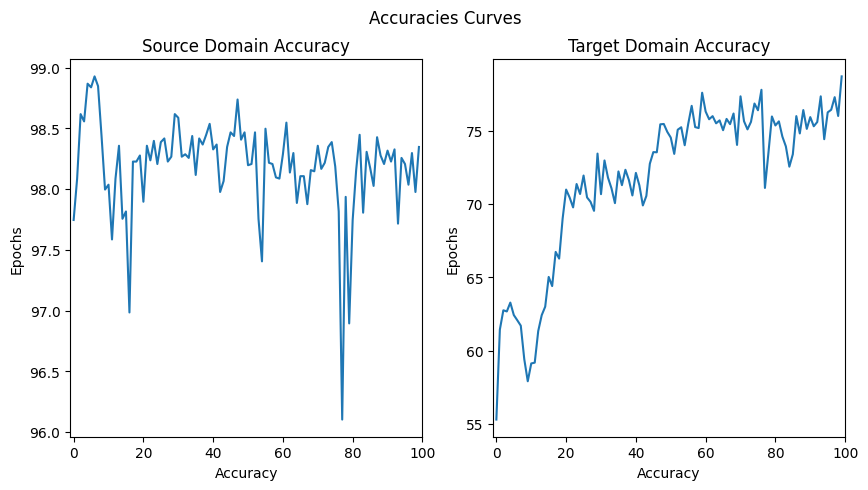

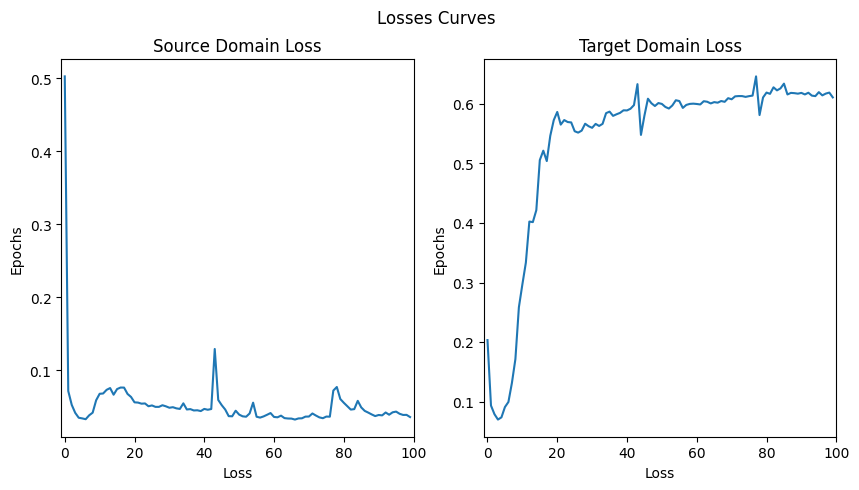

In [28]:
# Accuracies plot
plt.figure(figsize=(10, 5), dpi=100)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.plot(range(len(s_acc)), s_acc)
ax2.plot(range(len(t_acc)), t_acc)
plt.suptitle('Accuracies Curves')
ax1.title.set_text('Source Domain Accuracy')
ax1.set_xlim([-1, 100])
ax1.set_xlabel('Accuracy')
ax1.set_ylabel('Epochs')
ax2.title.set_text('Target Domain Accuracy')
ax2.set_xlim([-1, 100])
ax2.set_xlabel('Accuracy')
ax2.set_ylabel('Epochs')
plt.show()

# Losses plot
plt.figure(figsize=(10, 5), dpi=100)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.plot(range(len(c_loss)), c_loss)
ax2.plot(range(len(d_loss)), d_loss)
plt.suptitle('Losses Curves')
ax1.title.set_text('Source Domain Loss')
ax1.set_xlim([-1, 100])
ax1.set_xlabel('Loss')
ax1.set_ylabel('Epochs')
ax2.title.set_text('Target Domain Loss')
ax2.set_xlim([-1, 100])
ax2.set_xlabel('Loss')
ax2.set_ylabel('Epochs')
plt.show()

Finally, we may visualize the data representations learned by the network using the same code as above.

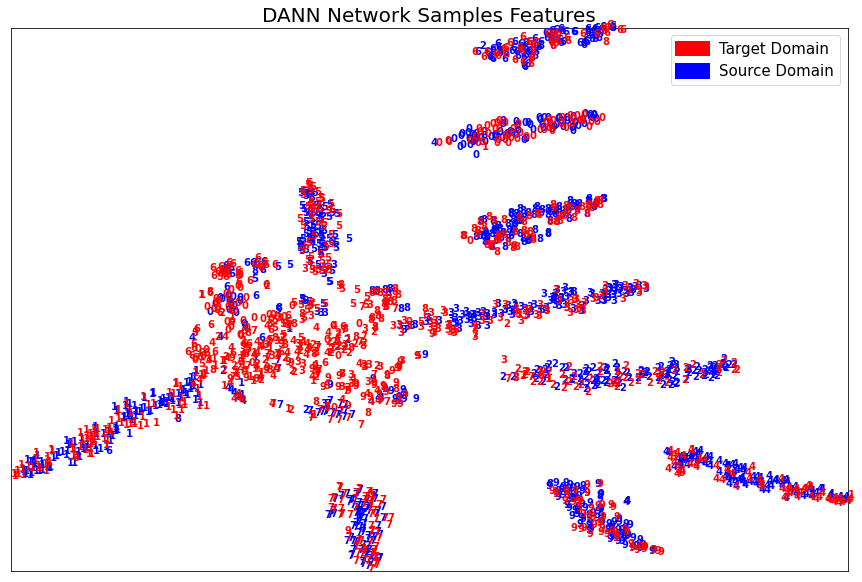

In [19]:
# Setup the network for evaluation
net.eval()

# Randomly select samples from source domain and target domain
num_of_samples = 1000 # number of samples
# lists to store images and labels
s_images, s_labels, s_tags = [], [], []
torch.manual_seed(0) # fixed seed for reproducibility

# Iterating through the source dataset
for images, labels in testloader_source:
    s_images.append(images.to(device)) # images
    s_labels.append(labels) # labels
    s_tags.append(torch.zeros((labels.size()[0])).type(torch.LongTensor)) # domains (0)
    # break when reaching the required number of samples
    if len(s_images * batch_size) > num_of_samples:
        break
# assuring number of samples
s_images, s_labels, s_tags = torch.cat(s_images)[:num_of_samples],torch.cat(s_labels)[:num_of_samples], torch.cat(s_tags)[:num_of_samples]

# Iterating through the target dataset
t_images, t_labels, t_tags = [], [], []
for images, labels in testloader_target:
    t_images.append(images.to(device)) # images
    t_labels.append(labels) # labels
    t_tags.append(torch.ones((labels.size()[0])).type(torch.LongTensor)) # domains (1)
    # break when reaching the required number of samples
    if len(t_images * batch_size) > num_of_samples:
        break
# assuring number of samples
t_images, t_labels, t_tags = torch.cat(t_images)[:num_of_samples], torch.cat(t_labels)[:num_of_samples], torch.cat(t_tags)[:num_of_samples]

# Compute the embedding of the images
embedding1, y1 = net(s_images)
embedding2, y2 = net(t_images)

# Compute the TSNE dimensionality reduction
# random state is for reproducibility
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000, random_state=0)
base_tsne = tsne.fit_transform(np.concatenate((embedding1.cpu().detach().numpy(),embedding2.cpu().detach().numpy())))

# Normalizing features
X = base_tsne
x_min, x_max = np.min(X, 0), np.max(X, 0)
X = (X - x_min) / (x_max - x_min)

# Concatenating labels and domains
y = np.concatenate((s_labels, t_labels))
d = np.concatenate((s_tags, t_tags))

# Plot colors numbers
plt.figure(figsize=(15,10))
ax = plt.subplot(111)

for i in range(X.shape[0]):
    # plot colored number
    plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.bwr(d[i]/1.),fontdict={'weight': 'bold', 'size': 10})
    plt.xticks([]), plt.yticks([])

# Plot figure
plt.title('DANN Network Samples Features', fontdict = {'fontsize' : 20})
red_patch = mpatches.Patch(color='red', label='Target Domain', linewidth=5)
blue_patch = mpatches.Patch(color='blue', label='Source Domain', linewidth=5)
plt.legend(handles=[red_patch, blue_patch], loc='upper right', fontsize=15)
plt.show()    